<a href="https://colab.research.google.com/github/willshpt/EE475stuff/blob/main/EE475HW6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import basic librariees and autograd wrapped numpy
from sklearn.datasets import fetch_openml
import sys
sys.path.append('../')
import autograd.numpy as np
import matplotlib.pyplot as plt
from autograd import grad
from autograd import hessian
from autograd import value_and_grad
from autograd.misc.flatten import flatten_func
import pandas as pd


# this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib inline
#from matplotlib import rcParams
#rcParams['figure.autolayout'] = True

# datapath to data
datapath = '/content/drive/MyDrive/Colab Notebooks/mlrefined_datasets/nonlinear_superlearn_datasets/'


from numba import njit, prange


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Exercise 10.4. Moore's law

## a) Propose a single feature transformation for the Moore's law dataset so that the transformed input/output data is related linearly *Hint: to produce a linear relationship you will have to transform the output, not the input.*

In [274]:
# import the dataset
csvname = datapath + 'transistor_counts.csv'
data = np.asarray(pd.read_csv(csvname,header = None))
x1 = data[:,0]
x1.shape = (1,len(x1))
y1old = data[:,1]
y1old.shape = (1,len(y1old))

mean1x = np.nanmean(x1, axis=1)[:,np.newaxis]
std1x = np.nanstd(x1, axis=1)[:,np.newaxis]
# Standardize the features
x1a = ((x1 - mean1x) / std1x)

mean1y = np.nanmean(y1old, axis=1)[:,np.newaxis]
std1y = np.nanstd(y1old, axis=1)[:,np.newaxis]
y1 = ((y1old - mean1y) / std1y)

print(np.shape(x1a))
print(np.shape(y1))

(1, 85)
(1, 85)


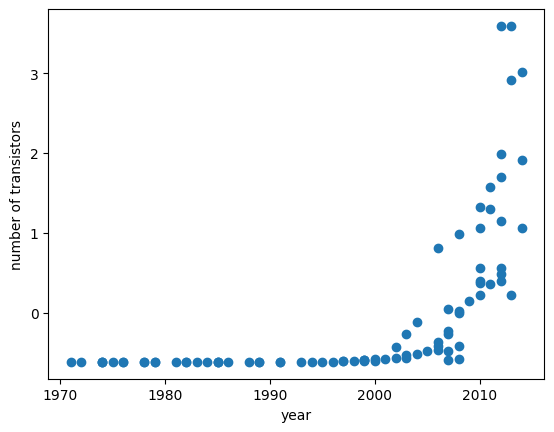

In [275]:
plt.scatter(x1, y1)
plt.xlabel("year")
plt.ylabel("number of transistors")
plt.show()

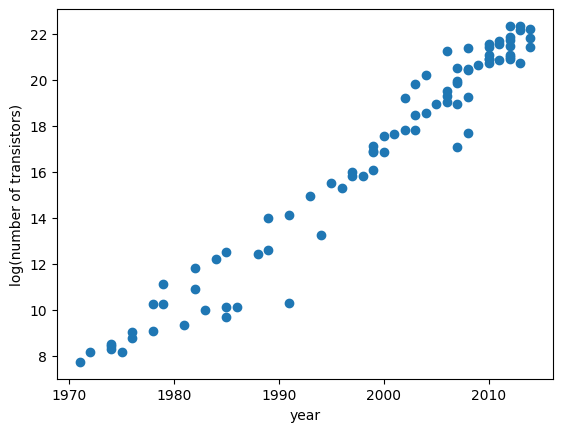

In [276]:
y1a = np.log(y1old)
plt.scatter(x1, y1a)
plt.xlabel("year")
plt.ylabel("log(number of transistors)")
plt.show()

<p style="page-break-after:always;"></p>

## b) Formulate and minimize a Least Squares cost function for appropriate weights, and fit your model to the data in the original data space

In [277]:
def feature_transforms1(x,w):
  f = np.exp(w[0] + np.dot(x.T,w[1:]))
  return f.T

In [278]:
def model1(x,theta):
  f = feature_transforms1(x,theta[0])
  a = theta[1][0] + np.dot(f.T,theta[1][1:]).T
  return a

In [279]:
def least_squares1(theta):
  cost = np.sum((model1(x1a,theta) - y1)**2)
  return cost/float(np.size(y1))

In [280]:
# gradient descent function - inputs: g (input function), alpha (steplength parameter), max_its (maximum number of iterations), w (initialization)
# Taken from the library to make sure it works better
from autograd import grad
def new_gradient_descent(g,alpha,max_its,w):
   g_flat, unflatten, w = flatten_func(g, w) # note here the output 'w' is also flattened

   # compute the gradient function of our input function - note this is a function too
   # that - when evaluated - returns both the gradient and function evaluations (remember
   # as discussed in Chapter 3 we always ge the function evaluation 'for free' when we use
   # an Automatic Differntiator to evaluate the gradient)
   gradient = value_and_grad(g_flat)

   # run the gradient descent loop
   weight_history = []      # container for weight history
   cost_history = []        # container for corresponding cost function history
   for k in range(1,max_its+1):
       # check if diminishing steplength rule used

       # evaluate the gradient, store current (unflattened) weights and cost function value
       cost_eval,grad_eval = gradient(w)
       weight_history.append(unflatten(w))
       cost_history.append(cost_eval)

       # take gradient descent step
       w = w - alpha*grad_eval

   # collect final weights
   weight_history.append(unflatten(w))
   # compute final cost function value via g itself (since we aren't computing
   # the gradient at the final step we don't get the final cost function value
   # via the Automatic Differentiatoor)
   cost_history.append(g_flat(w))
   return cost_history,weight_history

In [281]:
# newtons method function - inputs: g (input function), max_its (maximum number of iterations), w (initialization)
# Taken from the library to make sure it works better
def newtons_method(g,max_its,w,**kwargs):
    # flatten input funciton, in case it takes in matrices of weights
    flat_g, unflatten, w = flatten_func(g, w)

    # compute the gradient / hessian functions of our input function -
    # note these are themselves functions.  In particular the gradient -
    # - when evaluated - returns both the gradient and function evaluations (remember
    # as discussed in Chapter 3 we always ge the function evaluation 'for free' when we use
    # an Automatic Differntiator to evaluate the gradient)
    gradient = value_and_grad(flat_g)
    hess = hessian(flat_g)
     # set numericxal stability parameter / regularization parameter
    epsilon = 10**(-7)
    if 'epsilon' in kwargs:
        epsilon = kwargs['epsilon']

    # run the newtons method loop
    weight_history = []      # container for weight history
    cost_history = []        # container for corresponding cost function history
    for k in range(max_its):
        # evaluate the gradient, store current weights and cost function value
        cost_eval,grad_eval = gradient(w)
        weight_history.append(unflatten(w))
        cost_history.append(cost_eval)

        # evaluate the hessian
        hess_eval = hess(w)

        # reshape for numpy linalg functionality
        hess_eval.shape = (int((np.size(hess_eval))**(0.5)),int((np.size(hess_eval))**(0.5)))

        # solve second order system system for weight update
        w = w - np.dot(np.linalg.pinv(hess_eval + epsilon*np.eye(np.size(w))),grad_eval)

    # collect final weights
    weight_history.append(unflatten(w))
    # compute final cost function value via g itself (since we aren't computing
    # the gradient at the final step we don't get the final cost function value
    # via the Automatic Differentiatoor)
    cost_history.append(flat_g(w))
    return cost_history,weight_history

In [282]:
w_int1 = np.random.randn(2,1) + 7 * np.ones((2,1))
w_ext1 = 0.01*np.random.randn(2,1) + .005 * np.ones((2,1))
theta1 = np.array([w_int1, w_ext1])

print(theta1)
print(theta1.shape)

[[[7.47678085]
  [6.83404152]]

 [[0.02054442]
  [0.00796853]]]
(2, 2, 1)


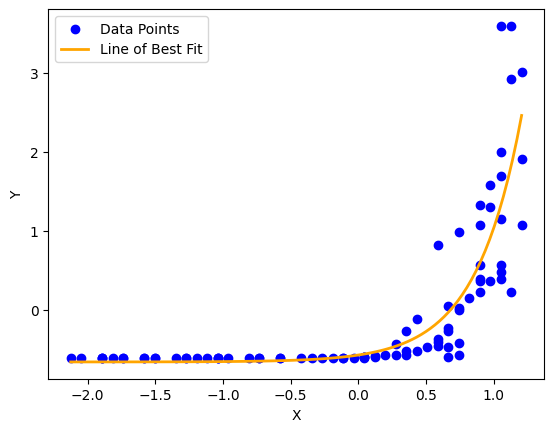

In [283]:
#a,b = new_gradient_descent(least_squares1,.1,500,theta1)
a,b = newtons_method(least_squares1,300,theta1)

ind = 0
if((not np.isnan(np.nanmin(a))) and (not np.nanargmin(a) == 0)):
  ind = np.nanargmin(a)
else:
  print("Model got weird")
#print(ind)
final_weights = b[ind]
intercept = final_weights[0]
slope = final_weights[1]
x_line = np.linspace(np.min(x1a), np.max(x1a), 100)[np.newaxis,:]
final_array = np.tile(final_weights, x_line.shape).T
y_line = model1(x_line, final_weights)

plt.scatter(x1a, y1, label='Data Points', color='b')
plt.plot(x_line[0], y_line[0], label='Line of Best Fit', color='orange', linewidth=2)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show();

<p style="page-break-after:always;"></p>

<p style="page-break-after:always;"></p>

# Exercise 10.8. Engineering features for a two-class classification dataset

Propose a nonlinear model for the dataset, it should be perfect (no misclassifications)

## Setup

In [248]:
csvname = datapath + 'diagonal_stripes.csv'
data = np.loadtxt(csvname, delimiter=',')

x2 = data[:2,:]
y2 = data[2:,:]

print(np.shape(x2))
print(np.shape(y2))

(2, 300)
(1, 300)


In [249]:
print(x2[0].shape)
print(np.min(y2))
print(np.max(y2))

(300,)
-1.0
1.0


<function matplotlib.pyplot.show(close=None, block=None)>

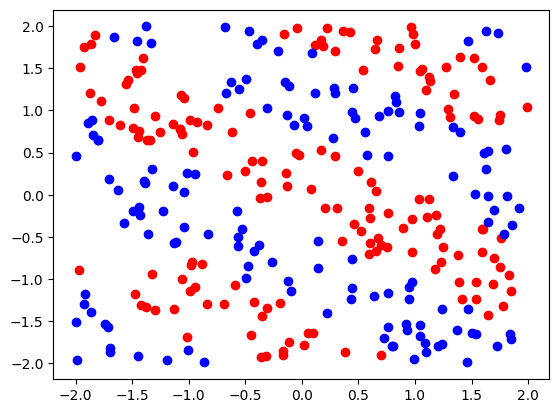

In [250]:
y2c1 = [[],[]]
y2c2 = [[],[]]
for i in range(y2.size):
  if(y2[0][i] == 1):
    y2c1[0].append(x2[0][i])
    y2c1[1].append(x2[1][i])
  else:
    y2c2[0].append(x2[0][i])
    y2c2[1].append(x2[1][i])
plt.scatter(y2c1[0],y2c1[1],color='red')
plt.scatter(y2c2[0],y2c2[1],color='blue')
plt.show

<p style="page-break-after:always;"></p>

In [251]:
# The shape is a sine wave along x0 = x1
def feature_transforms2(x,w):
  a = x[0]*w[1] + x[1]*w[2]
  f = np.sin(w[0] + a)
  return f

In [252]:
def model2(x,theta):
  f = feature_transforms2(x,np.array(theta[0:3]))
  return f[np.newaxis,:]

In [253]:
def softmax2(w):
  cost = np.sum(np.log(1 + np.exp(-y2*model2(x2,w))))
  a = cost/float(np.size(y2))
  return a

In [254]:
def perceptron2(w):
    predictions = -y2 * model2(x2, w)
    misclassified = np.maximum(0, predictions)
    cost = np.sum(misclassified)
    return cost / float(np.size(y2))

In [255]:
theta2 = np.array([-1.3, 1.6, 1.6, 1, 1])
print(theta2.shape)

(5,)


In [256]:
#a,b = new_gradient_descent(softmax2,10**-5,1000,theta2)
a,b = newtons_method(perceptron2,100,theta2, epsilon=10**-5)

In [257]:
def get_misclass_history(w_list,x,y):
  yo = np.int_(np.array(y))
  misclasslist = []
  for w in w_list:
    yp = np.int_(-np.sign(model2(x,w)))
    misclassifications = np.sum(np.not_equal(yp,yo).astype(int))
    #print(yo)
    #print(yp)
    misclasslist.append(misclassifications)
  return misclasslist

In [258]:
hista = get_misclass_history(b, x2, y2)
inda = np.argmin(get_misclass_history(b, x2, y2))
print(inda)
print(hista[inda])
print(hista[-1])

6
7
7


In [259]:
def misclass_helper(a, b, c):
  cost, weights = newtons_method(perceptron2, 10, np.array([a,b,c,0,0]), epsilon=10**-5)
  hist = get_misclass_history(weights,x2,y2)
  return np.min(hist)

def misclass_minimizer(alist, blist, clist):
  min_misclass = 300
  amin = 0
  bmin = 0
  cmin = 0
  for a in alist:
    for b in blist:
      for c in clist:
        misclasses = misclass_helper(a,b,c)
        if misclasses < min_misclass:
          min_misclass = misclasses
          amin = a
          bmin = b
          cmin = c
  return min_misclass,amin,bmin,cmin

In [260]:
misclass, at, bt, ct = misclass_minimizer(np.linspace(-3.1,-2.9,3).tolist(),np.linspace(1.7,2.0,4).tolist(),np.linspace(2.0,2.3,5).tolist())
print(at) #-3
print(bt) # 1.8
print(ct) # 2.23232323
print(misclass)
cost2,weights2 = newtons_method(perceptron2,100, np.array([at,bt,ct,0,0]), epsilon=10**-5)
histb = get_misclass_history(weights2, x2, y2)
indb = np.argmin(histb)
print(indb)
print(histb[indb])
print(histb[-1])

-3.0
1.9
2.3
0
4
0
6


In [261]:
theta2a = weights2[indb]
print(theta2a)
histc = get_misclass_history(theta2a[np.newaxis,:], x2, y2)
indc = np.argmin(histc)
print(indc)
print(histc[indc])
print(histc[-1])

[-2.11238229  2.00050275  3.00032942  0.          0.        ]
0
0
0


(1, 300)


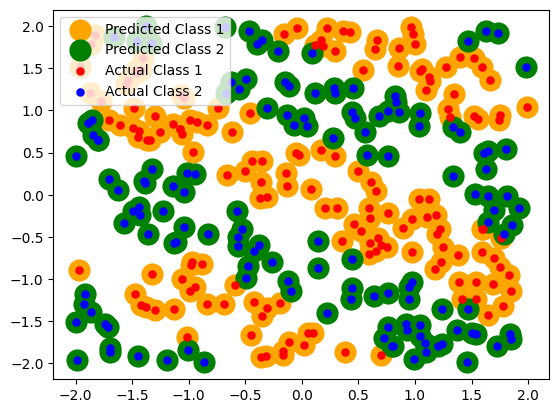

In [262]:
y2c12 = [[],[]]
y2c22 = [[],[]]
y22 = model2(x2, weights2[4])
print(y22.shape)
for i in range(y22.shape[1]):
  if(y22[0][i] < 0):
    y2c12[0].append(x2[0][i])
    y2c12[1].append(x2[1][i])
  else:
    y2c22[0].append(x2[0][i])
    y2c22[1].append(x2[1][i])
plt.scatter(y2c12[0],y2c12[1],color='orange',linewidth=10, label="Predicted Class 1")
plt.scatter(y2c22[0],y2c22[1],color='green',linewidth=10, label="Predicted Class 2")
plt.scatter(y2c1[0],y2c1[1],color='red',linewidth=.1, label="Actual Class 1")
plt.scatter(y2c2[0],y2c2[1],color='blue',linewidth=.1, label="Actual Class 2")
plt.legend()
plt.show()

<p style="page-break-after:always;"></p>

## And now to put it all together

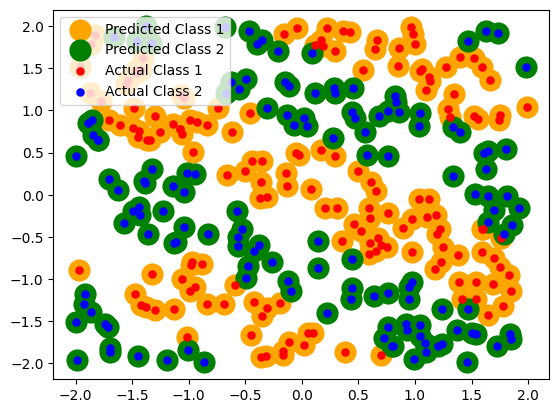

Misclassifications:  0


In [263]:
# Chose a very specific theta to make sure it is 0,
theta2f = np.array([-2.1123, 2.00, 3.00, 0, 0])
cost2f,weights2f = newtons_method(perceptron2,100, theta2f, epsilon=10**-5)
hist2f = get_misclass_history(weights2f, x2, y2)
ind2f = np.argmin(hist2f)
final_weights2 = weights2f[ind2f]
y_pred2 = model2(x2, final_weights2)
y2c1f = [[],[]]
y2c2f = [[],[]]
for i in range(y_pred2.shape[1]):
  if(y_pred2[0][i] < 0):
    y2c1f[0].append(x2[0][i])
    y2c1f[1].append(x2[1][i])
  else:
    y2c2f[0].append(x2[0][i])
    y2c2f[1].append(x2[1][i])
plt.scatter(y2c1f[0],y2c1f[1],color='orange',linewidth=10, label="Predicted Class 1")
plt.scatter(y2c2f[0],y2c2f[1],color='green',linewidth=10, label="Predicted Class 2")
plt.scatter(y2c1[0],y2c1[1],color='red',linewidth=.1, label="Actual Class 1")
plt.scatter(y2c2[0],y2c2[1],color='blue',linewidth=.1, label="Actual Class 2")
plt.legend()
plt.show()
print("Misclassifications: ", hist2f[ind2f])



<p style="page-break-after:always;"></p>


# Exercise 11.1. Naive cross-validation I

Split the data randomly into 2/3 training and 1/3 validation. The set of models are polynomials of degree 1 <= m <= 8. Make a plot showing training and validation error for range of models tested, and visualize the model you find (along with the data) that provides the lowest validation error.

In [264]:
csvname = datapath + 'noisy_sin_sample.csv'

data = np.loadtxt(csvname, delimiter = ',')
x3 = data[:-1,:]
y3 = data[-1:,:]

print(np.shape(x3))
print(np.shape(y3))

(1, 21)
(1, 21)


In [265]:
# newtons method function - inputs: g (input function), max_its (maximum number of iterations), w (initialization)
def newtons_method(g,max_its,w,**kwargs):
    # flatten input funciton, in case it takes in matrices of weights
    flat_g, unflatten, w = flatten_func(g, w)

    # compute the gradient / hessian functions of our input function -
    # note these are themselves functions.  In particular the gradient -
    # - when evaluated - returns both the gradient and function evaluations (remember
    # as discussed in Chapter 3 we always ge the function evaluation 'for free' when we use
    # an Automatic Differntiator to evaluate the gradient)
    gradient = value_and_grad(flat_g)
    hess = hessian(flat_g)
     # set numericxal stability parameter / regularization parameter
    epsilon = 10**(-7)
    if 'epsilon' in kwargs:
        epsilon = kwargs['epsilon']

    # run the newtons method loop
    weight_history = []      # container for weight history
    cost_history = []        # container for corresponding cost function history
    for k in range(max_its):
        # evaluate the gradient, store current weights and cost function value
        cost_eval,grad_eval = gradient(w)
        weight_history.append(unflatten(w))
        cost_history.append(cost_eval)

        # evaluate the hessian
        hess_eval = hess(w)

        # reshape for numpy linalg functionality
        hess_eval.shape = (int((np.size(hess_eval))**(0.5)),int((np.size(hess_eval))**(0.5)))

        # solve second order system system for weight update
        w = w - np.dot(np.linalg.pinv(hess_eval + epsilon*np.eye(np.size(w))),grad_eval)

    # collect final weights
    weight_history.append(unflatten(w))
    # compute final cost function value via g itself (since we aren't computing
    # the gradient at the final step we don't get the final cost function value
    # via the Automatic Differentiatoor)
    cost_history.append(flat_g(w))
    return cost_history,weight_history

In [266]:
training_indices3 = np.sort(np.random.choice(np.shape(x3)[1], int(2*np.shape(x3)[1]/3), replace=False))
validation_indices3 = np.delete(np.arange(np.shape(x3)[1]), training_indices3)
print(training_indices3)
print(validation_indices3)
x3train = x3[0][training_indices3]
x3valid = x3[0][validation_indices3]
y3train = y3[0][training_indices3]
y3valid = y3[0][validation_indices3]

[ 2  3  5  6  7  9 10 11 13 14 15 16 18 19]
[ 0  1  4  8 12 17 20]


In [267]:
def least_squares3(w,m):
    cost = np.sum((models3(x3train,w,m) - y3train)**2)
    return cost/float(np.size(y3train))

In [268]:
def least_squares3v(w,m):
    cost = np.sum((models3(x3valid,w,m) - y3valid)**2)
    return cost/float(np.size(y3valid))

In [269]:
def least_squares3o(w,m):
    cost = np.sum((models3(x3,w,m) - y3)**2)
    return cost/float(np.size(y3))

In [270]:
def feature_transforms3(x,m):
    # calculate feature transform
    f = np.array([(x.flatten()**d) for d in range(0,m)])
    return f

In [271]:
def models3(x,w,m):
  f = feature_transforms3(x,m)
  a = w[0] + np.dot(f.T, w[1:])
  return a.T

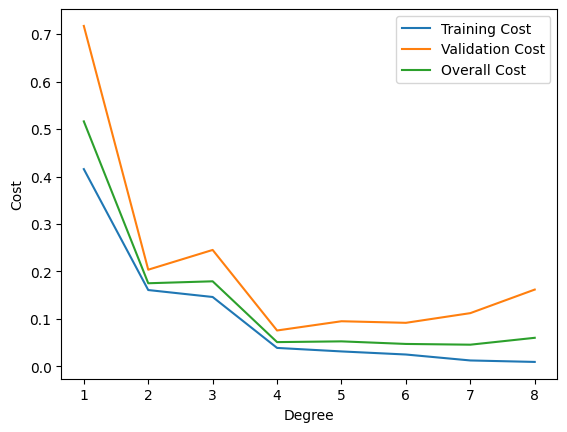

In [272]:
degrees = np.arange(1,9)
tcost = []
vcost = []
ocost = []
for j in degrees:
  w3 = 0.3*np.random.randn(j + 1,1)
  a,b = newtons_method(lambda w : least_squares3(w,j),100,w3)
  minind = np.argmin(a)
  wmin = b[minind]
  tcost.append(least_squares3(wmin, j))
  vcost.append(least_squares3v(wmin, j))
  ocost.append(least_squares3o(wmin, j))
plt.plot(degrees, tcost, label="Training Cost")
plt.plot(degrees, vcost, label="Validation Cost")
plt.plot(degrees, ocost, label="Overall Cost")
plt.xlabel('Degree')
plt.ylabel('Cost')
plt.legend()
plt.show()

<p style="page-break-after:always;"></p>

Degree:  4


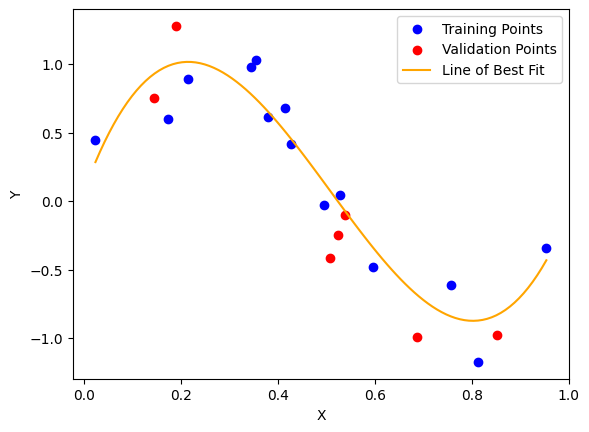

In [273]:
m = degrees[np.argmin(vcost)]
print("Degree: ", m)
w3 = 0.1*np.random.randn(m+1,1)
a3,b3 = newtons_method(lambda w : least_squares3(w,m),100,w3)
minind3 = np.argmin(a3)
wmin3 = b3[minind3]
x_line3 = np.linspace(np.min(x3), np.max(x3), 100)[np.newaxis,:]
y_line3 = models3(x_line3, wmin3, m)
plt.scatter(x3train, y3train, label='Training Points', color='b')
plt.scatter(x3valid, y3valid, label='Validation Points', color='r')
plt.plot(x_line3[0], y_line3[0], label='Line of Best Fit', color='orange')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show();



<p style="page-break-after:always;"></p>


# Exercise 11.3. Boosting based cross-validation I

Two-class classification using a dataset of P=99 datapoints that has a (roughly) circular decision boundary. Split the data randomly into 2/3 training and 1/3 validation, and employ neural network units for bosting. Do M=30 rounds of boosting, and make a plot showing the training and validation errors. Use neural network boosting.

In [286]:
# Load in data
csvname = datapath + 'new_circle_data.csv'
data = np.loadtxt(csvname, delimiter = ',')

x4old = data[:-1,:]
y4 = data[-1:,:]

mean_values4 = np.mean(x4old, axis=1, keepdims=True)
std_values4 = np.std(x4old, axis=1, keepdims=True)
x4 = (x4old-mean_values4)/std_values4

print(np.shape(x4))
print(np.shape(y4))

(2, 99)
(1, 99)


## Setup

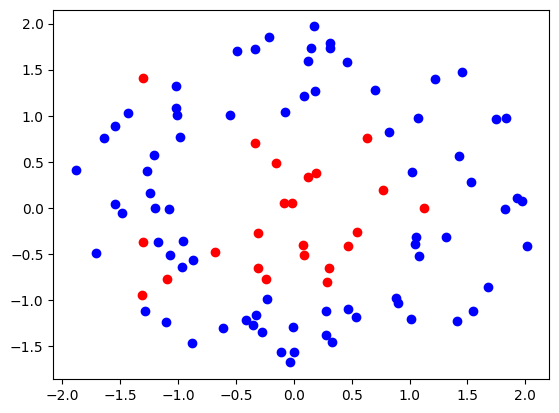

In [287]:
# Visualize data
y4c1 = [[],[]]
y4c2 = [[],[]]
for i in range(y4.size):
  if(y4[0][i] == 1):
    y4c1[0].append(x4[0][i])
    y4c1[1].append(x4[1][i])
  else:
    y4c2[0].append(x4[0][i])
    y4c2[1].append(x4[1][i])
plt.scatter(y4c1[0],y4c1[1],color='red')
plt.scatter(y4c2[0],y4c2[1],color='blue')
plt.show()

<p style="page-break-after:always;"></p>

In [288]:
# newtons method function - inputs: g (input function), max_its (maximum number of iterations), w (initialization)
def newtons_method(g,max_its,w,**kwargs):
    # flatten input funciton, in case it takes in matrices of weights
    flat_g, unflatten, w = flatten_func(g, w)

    # compute the gradient / hessian functions of our input function -
    # note these are themselves functions.  In particular the gradient -
    # - when evaluated - returns both the gradient and function evaluations (remember
    # as discussed in Chapter 3 we always ge the function evaluation 'for free' when we use
    # an Automatic Differntiator to evaluate the gradient)
    gradient = value_and_grad(flat_g)
    hess = hessian(flat_g)
     # set numericxal stability parameter / regularization parameter
    epsilon = 10**(-7)
    if 'epsilon' in kwargs:
        epsilon = kwargs['epsilon']

    # run the newtons method loop
    weight_history = []      # container for weight history
    cost_history = []        # container for corresponding cost function history
    for k in range(max_its):
        # evaluate the gradient, store current weights and cost function value
        cost_eval,grad_eval = gradient(w)
        weight_history.append(unflatten(w))
        cost_history.append(cost_eval)

        # evaluate the hessian
        hess_eval = hess(w)

        # reshape for numpy linalg functionality
        hess_eval.shape = (int((np.size(hess_eval))**(0.5)),int((np.size(hess_eval))**(0.5)))

        # solve second order system system for weight update
        w = w - np.dot(np.linalg.pinv(hess_eval + epsilon*np.eye(np.size(w))),grad_eval)

    # collect final weights
    weight_history.append(unflatten(w))
    # compute final cost function value via g itself (since we aren't computing
    # the gradient at the final step we don't get the final cost function value
    # via the Automatic Differentiatoor)
    cost_history.append(flat_g(w))
    return cost_history,weight_history

In [289]:
training_indices4 = np.sort(np.random.choice(np.shape(x4)[1], int(2*np.shape(x4)[1]/3), replace=False))
validation_indices4 = np.delete(np.arange(np.shape(x4)[1]), training_indices4)
x4train = x4.T[training_indices4].T
x4valid = x4.T[validation_indices4].T
y4train = y4[0][training_indices4]
y4valid = y4[0][validation_indices4]
print(x4.shape)
print(x4train.shape)

(2, 99)
(2, 66)


## Things that may change

In [290]:
def initial_model4(x,w):
  return (w*np.ones((1,x.shape[1])))

In [291]:
def softmax4_train(w,model):
  cost = np.sum(np.log(1 + np.exp(-y4train*model(x4train,w))))
  a = cost/float(np.size(y4train))
  return a

In [292]:
def softmax4_validate(w,model):
  cost = np.sum(np.log(1 + np.exp(-y4valid*model(x4valid,w))))
  a = cost/float(np.size(y4valid))
  return a

In [293]:
def softmax4_overall(w,model):
  cost = np.sum(np.log(1 + np.exp(-y4*model(x4,w))))
  a = cost/float(np.size(y4))
  return a

In [294]:
def perceptron4(x, w):
        # compute inner product with current layer weights
        f = feature_transforms4(x,w)
        a = w[0][0] + np.dot(f.T, w[0][1:])
        # output of layer activation
        a = np.maximum(0,a).T
        # final linear combo
        a = w[1][0] + np.dot(a.T,w[1][1:])
        return a.T

In [295]:
def get_misclass_history4(w_list,x,y,model):
  yo = np.int_(np.array(y))
  misclasslist = []
  for w in w_list:
    yp = np.int_(np.sign(model(x,w)))
    misclassifications = np.sum(np.not_equal(yp,yo).astype(int))
    misclasslist.append(misclassifications)
  return misclasslist

In [296]:
def misclass_calc(model, x, true_labels, threshold=0):
    # Get model predictions
    predicted_probs = model(x)
    # Convert predicted probabilities to binary predictions based on the threshold
    binary_predictions = (predicted_probs >= threshold).astype(int)
    binary_predictions = np.array([-1 if x == 0 else x for x in binary_predictions[0]])
    # Count misclassifications
    misclassifications = np.sum(binary_predictions != true_labels)
    return misclassifications


In [297]:
def feature_transforms4(x,w):
    # calculate feature transform

    # No transform
    #f = x

    # Simple circle
    #f = x**2

    # Test
    #f = (np.abs(x) + x**2)/2

    # Polar
    f = np.array([np.sqrt(x[0]**2 + x[1]**2), np.arctan(x[1]/x[0])])

    # Complex sin thing
    #alpha = 4*w[0][2]
    #f = np.array([np.cos((w[0][0]+x[0])*alpha)+x[0]**2, np.cos((w[0][1]+x[1])*alpha)+x[1]**2])

    # Moving circle
    #alpha = 280
    #alpha1 = 1.9
    #alpha2 = 1.9
    #f = np.array([((x[0] + w[2][0]*alpha1)**2)*np.abs(w[2][1])*alpha*w[2][4], ((x[1] + w[2][2]*alpha2)**2)*np.abs(w[2][3])*alpha*w[2][5]])
    #print(f.shape)
    return f

In [298]:
def neural_net_boosting_learner(num_steps, max_its, scale):
  step_array = np.arange(1,num_steps)
  best_units = []
  model_history = []
  training_cost_history = []
  validation_cost_history = []
  combined_cost_history = []
  training_misclassification_history = []
  validation_misclassification_history = []
  combined_misclassification_history = []
  w_best_history = []
  model_0 = initial_model4;
  unfinished = True;
  s_factor = 1.0
  while unfinished:
    scale_temp = round(scale*s_factor,4);
    #print("Step: ", 0)
    #print("Scale: ", scale_temp)
    w = scale_temp*np.random.randn(1)
    try:
      cost_hist, weight_hist = newtons_method(lambda w : softmax4_train(w, model_0), max_its, w)
      unfinished = False
    except np.linalg.LinAlgError:
      #print("Did not converge! Decreasing scale")
      s_factor = s_factor - 0.1
  ind = np.argmin(cost_hist)
  w_best = weight_hist[ind]
  w_best_history.append(w_best)
  model = lambda x,w=w_best : model_0(x,w)
  best_units.append(model)
  model_history.append(model)
  training_cost_history.append(softmax4_train(w_best,model))
  validation_cost_history.append(softmax4_validate(w_best,model))
  combined_cost_history.append(softmax4_overall(w_best,model))
  training_misclassification_history.append(misclass_calc(model, x4train, y4train))
  validation_misclassification_history.append(misclass_calc(model, x4valid, y4valid))
  combined_misclassification_history.append(misclass_calc(model, x4, y4))
  for j in step_array:
    next_unit = lambda x,w: perceptron4(x,w)
    current_model = lambda x,w: model(x) + next_unit(x,w)
    unfinished = True;
    s_factor = 1.0
    while unfinished:
      scale_temp = round(scale*s_factor,4);
      #print("Step: ", j)
      #print("Scale: ", scale_temp)
      w = [scale_temp*np.random.randn(x4train.shape[0] + 1,1), scale_temp*np.random.randn(2,1), scale_temp*np.random.randn(6,1)]
      try:
        cost_hist, weight_hist = newtons_method(lambda w : softmax4_train(w, current_model), max_its, w)
        unfinished = False
      except np.linalg.LinAlgError:
        #print("Did not converge! Decreasing scale")
        s_factor = s_factor * 0.9
    ind = np.argmin(cost_hist)
    w_best = weight_hist[ind]
    w_best_history.append(w_best)
    best_perceptron = lambda x,w=w_best: next_unit(x,w)
    best_units.append(best_perceptron)
    next_model = lambda x,w=w_best : current_model(x,w)
    model_history.append(next_model)
    training_cost_history.append(softmax4_train(w_best,next_model))
    validation_cost_history.append(softmax4_validate(w_best,next_model))
    combined_cost_history.append(softmax4_overall(w_best,next_model))
    training_misclassification_history.append(misclass_calc(next_model, x4train, y4train))
    validation_misclassification_history.append(misclass_calc(next_model, x4valid, y4valid))
    combined_misclassification_history.append(misclass_calc(next_model, x4, y4))
    model = lambda x,units=best_units: np.sum([v(x) for v in units],axis=0)
    #print("Misclassifications: ", combined_misclassification_history[-1])
  return w_best_history, best_units, model_history, training_cost_history, validation_cost_history, combined_cost_history, training_misclassification_history, validation_misclassification_history, combined_misclassification_history

/usr/local/lib/python3.10/dist-packages/autograd/numpy/numpy_vjps.py:53: RuntimeWarning: overflow encountered in square
  lambda ans, x, y : unbroadcast_f(y, lambda g: - g * x / y**2))


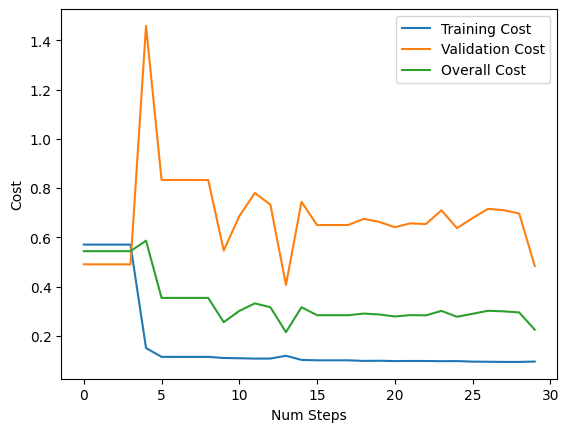

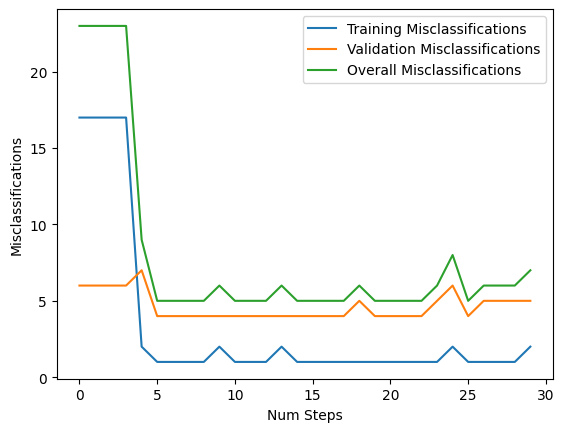

In [299]:
num_steps4 = 30
max_its4 = 100
scale4 = 1.3
w_best_hist4, best_units4, model_history4, tcost_hist4, vcost_hist4, ccost_hist4, tmisclass_hist4, vmisclass_hist4, cmisclass_hist4 = neural_net_boosting_learner(num_steps4,max_its4,scale4)
true_steps = np.arange(0, np.array(tcost_hist4).shape[0])
plt.plot(true_steps, tcost_hist4, label="Training Cost")
plt.plot(true_steps, vcost_hist4, label="Validation Cost")
plt.plot(true_steps, ccost_hist4, label="Overall Cost")
plt.xlabel('Num Steps')
plt.ylabel('Cost')
plt.legend()
plt.show()
plt.plot(true_steps, tmisclass_hist4, label="Training Misclassifications")
plt.plot(true_steps, vmisclass_hist4, label="Validation Misclassifications")
plt.plot(true_steps, cmisclass_hist4, label="Overall Misclassifications")
plt.xlabel('Num Steps')
plt.ylabel('Misclassifications')
plt.legend()
plt.show()

<p style="page-break-after:always;"></p>

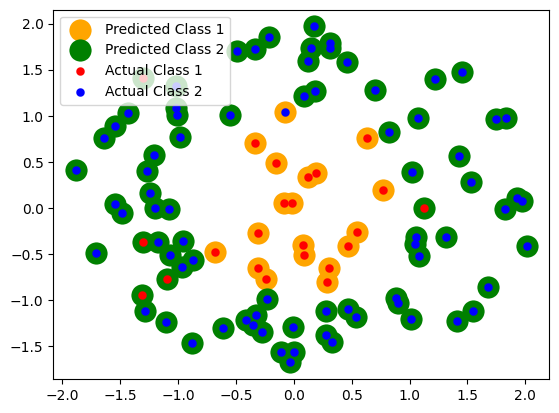

Misclassifications:  6


In [300]:
best_ind4 = np.argmin(cmisclass_hist4)
best_model4 = model_history4[best_ind4]
w4f = w_best_hist4[best_ind4]
y_pred4 = best_model4(x4,w4f)
y4c1f = [[],[]]
y4c2f = [[],[]]
for i in range(y_pred4.shape[1]):
  if(y_pred4[0][i] > 0):
    y4c1f[0].append(x4[0][i])
    y4c1f[1].append(x4[1][i])
  else:
    y4c2f[0].append(x4[0][i])
    y4c2f[1].append(x4[1][i])
plt.scatter(y4c1f[0],y4c1f[1],color='orange',linewidth=10, label="Predicted Class 1")
plt.scatter(y4c2f[0],y4c2f[1],color='green',linewidth=10, label="Predicted Class 2")
plt.scatter(y4c1[0],y4c1[1],color='red',linewidth=.1, label="Actual Class 1")
plt.scatter(y4c2[0],y4c2[1],color='blue',linewidth=.1, label="Actual Class 2")
plt.legend()
plt.show()
print("Misclassifications: ", misclass_calc(best_model4,x4,y4))

I also attempted some different feature transformations, as well as no feature transformation, and got varying results.

<p style="page-break-after:always;"></p>

# Old



In [ ]:
def feature_transforms4(x,m):
    # calculate feature transform
    #print(x.shape)
    f = x**2
    #print("F: ", f)
    #print(f.shape)
    return f

In [ ]:
def perceptron4(x, w):
        #print(w[0].shape)
        #print(x.shape)
        # compute inner product with current layer weights
        a = w[0][0] + np.dot(x.T, w[0][1:])

        # output of layer activation
        #print(a.shape)
        a = np.maximum(0,a).T

        # final linear combo
        a = w[1][0] + np.dot(a.T,w[1][1:])
        return a.T

In [ ]:
def models4_0(x,w):
  return (w*np.ones((1,x.shape[1])))

In [ ]:
lam = 10**(-5)
def softmax4a(w,model=models4_0):
  cost = np.sum(np.log(1 + np.exp(-y4train*model(x4train,w))))
  cost = cost + lam*np.linalg.norm(w[0],'fro')**2
  a = cost/float(np.size(y4train))
  #print(a)
  return a

In [ ]:
def softmax4(w,model=models4_0):
  cost = np.sum(np.log(1 + np.exp(-y4train*model(x4train,w))))
  a = cost/float(np.size(y4train))
  #print(a)
  return a

In [ ]:
def softmax4v(w,model=models4_0):
  cost = np.sum(np.log(1 + np.exp(-y4valid*model(x4valid,w))))
  a = cost/float(np.size(y4valid))
  #print(a)
  return a

In [ ]:
def softmax4o(w,model=models4_0):
  cost = np.sum(np.log(1 + np.exp(-y4*model(x4,w))))
  a = cost/float(np.size(y4))
  #print(a)
  return a

In [ ]:
def misclass_calc(model, x, true_labels, threshold=0):
    # Get model predictions
    predicted_probs = model(x)

    # Convert predicted probabilities to binary predictions based on the threshold
    binary_predictions = (predicted_probs >= threshold).astype(int)

    # Count misclassifications
    misclassifications = np.sum(binary_predictions != true_labels)

    return misclassifications


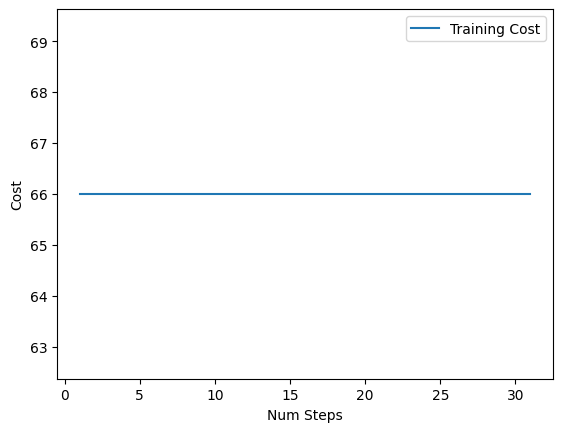

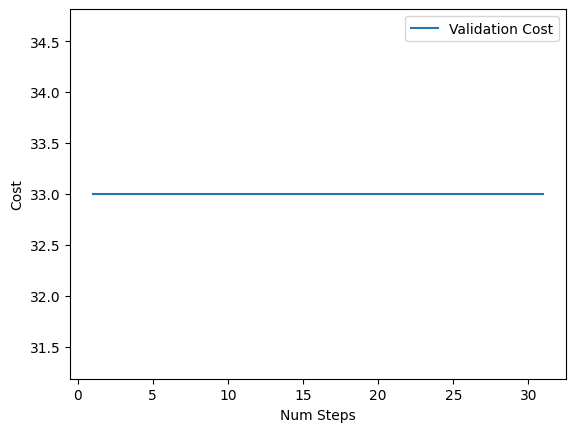

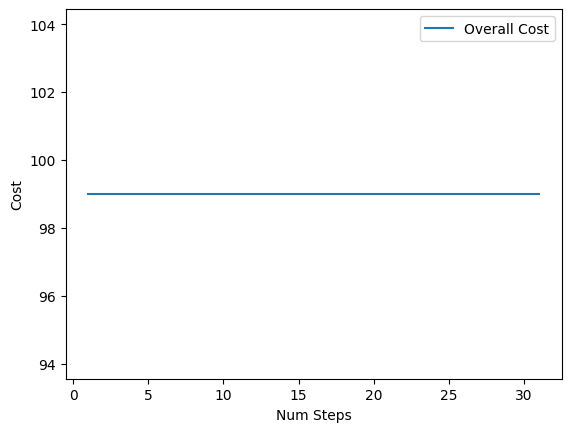

In [ ]:
num_steps = np.arange(1,31)
true_steps = np.arange(1,32)
best_steps = []
models = []
tcost4 = []
vcost4 = []
ocost4 = []
max_its4 = 10
w40 = 0.01*np.ones((1,1))
a40,b40 = newtons_method(softmax4,max_its4,w40)
ind40 = np.argmin(a40)
w_best40 = b40[ind40]
model40 = lambda x,w=w_best40:models4_0(x,w)
best_steps.append(model40)
models.append(model40)
modelit = lambda x,steps=best_steps: np.sum([v(x) for v in steps],axis=0)
tcost4.append(misclass_calc(modelit, x4train, y4train))
vcost4.append(misclass_calc(modelit, x4valid, y4valid))
ocost4.append(misclass_calc(modelit, x4, y4))
for j in num_steps:
  #print(x4train.shape)
  scale = -.001
  U = 1
  w4 = [scale*np.random.randn(x4train.shape[0] + 1,U), scale*np.random.randn(2,U)]
  #print(w4)
  next_unit = lambda x,w: perceptron4(x,w)
  c_model = lambda x,w : modelit(x) + next_unit(x,w)
  #w4 = 0.1*np.random.randn(j,1)
  a,b = newtons_method(lambda w : softmax4a(w,model=c_model),max_its4,w4)
  #print(j)
  #print(b[0].shape)
  #print(w3.shape)
  minind = np.argmin(a)
  wmin = b[minind]
  tcost4.append(misclass_calc(modelit, x4train, y4train))
  vcost4.append(misclass_calc(modelit, x4valid, y4valid))
  ocost4.append(misclass_calc(modelit, x4, y4))
  best_perceptron = lambda x,w=wmin : next_unit(x,w)
  best_steps.append(best_perceptron)
  modelit = lambda x,steps=best_steps: np.sum([v(x) for v in steps],axis=0)
  models.append(modelit)
plt.plot(true_steps, tcost4, label="Training Cost")
plt.xlabel('Num Steps')
plt.ylabel('Cost')
plt.legend()
plt.show()
plt.plot(true_steps, vcost4, label="Validation Cost")
plt.xlabel('Num Steps')
plt.ylabel('Cost')
plt.legend()
plt.show()
plt.plot(true_steps, ocost4, label="Overall Cost")
plt.xlabel('Num Steps')
plt.ylabel('Cost')
plt.legend()
plt.show()

[[-1.40534256 -1.40534256 -1.40534256 -1.40534256 -1.40534256 -1.40534256
  -1.40534256 -1.40534256 -1.40534256 -1.40534256 -1.40534256 -1.40534256
  -1.40534256 -1.40534256 -1.40534256 -1.40534256 -1.40534256 -1.40534256
  -1.40534256 -1.40534256 -1.40534256 -1.40534256 -1.40534256 -1.40534256
  -1.40534256 -1.40534256 -1.40534256 -1.40534256 -1.40534256 -1.40534256
  -1.40534256 -1.40534256 -1.40534256 -1.40534256 -1.40534256 -1.40534256
  -1.40534256 -1.40534256 -1.40534256 -1.40534256 -1.40534256 -1.40534256
  -1.40534256 -1.40534256 -1.40534256 -1.40534256 -1.40534256 -1.40534256
  -1.40534256 -1.40534256 -1.40534256 -1.40534256 -1.40534256 -1.40534256
  -1.40534256 -1.40534256 -1.40534256 -1.40534256 -1.40534256 -1.40534256
  -1.40534256 -1.40534256 -1.40534256 -1.40534256 -1.40534256 -1.40534256
  -1.40534256 -1.40534256 -1.40534256 -1.40534256 -1.40534256 -1.40534256
  -1.40534256 -1.40534256 -1.40534256 -1.40534256 -1.40534256 -1.40534256
  -1.40534256 -1.40534256 -1.40534256 

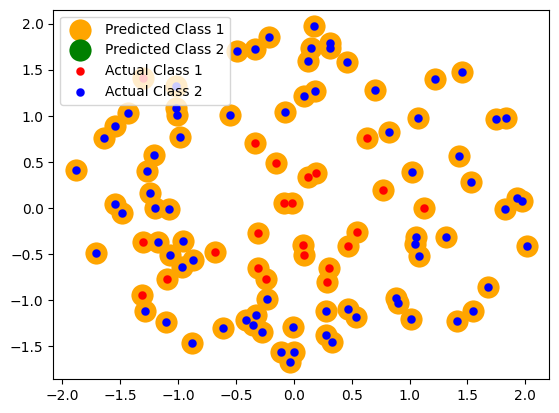

Misclassifications:  0


In [ ]:
w4f = [scale*np.random.randn(x4.shape[0] + 1,U), scale*np.random.randn(2,U)]
cost4f,weights4f = newtons_method(lambda w : softmax4o(w,model=c_model),100, w4f, epsilon=10**-5)
hist4f = get_misclass_history(weights2f, x2, y2)
ind4f = np.argmin(hist2f)
final_weights4 = weights4f[ind4f]
y_pred4 = models[0](x4)
print(y_pred4)
y4c1f = [[],[]]
y4c2f = [[],[]]
for i in range(y_pred4.shape[1]):
  if(y_pred4[0][i] < 0):
    y4c1f[0].append(x4[0][i])
    y4c1f[1].append(x4[1][i])
  else:
    y4c2f[0].append(x4[0][i])
    y4c2f[1].append(x4[1][i])
plt.scatter(y4c1f[0],y4c1f[1],color='orange',linewidth=10, label="Predicted Class 1")
plt.scatter(y4c2f[0],y4c2f[1],color='green',linewidth=10, label="Predicted Class 2")
plt.scatter(y4c1[0],y4c1[1],color='red',linewidth=.1, label="Actual Class 1")
plt.scatter(y4c2[0],y4c2[1],color='blue',linewidth=.1, label="Actual Class 2")
#plt.scatter(x2[0]+x2[1],y22)
plt.legend()
plt.show()
print("Misclassifications: ", hist2f[ind2f])